# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [100]:
! git clone https://github.com/ds4e/linearModels


fatal: destination path 'linearModels' already exists and is not an empty directory.


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression


1. Clean the data and perform some EDA and visualization to get to know the data set.


In [102]:
df = pd.read_csv('./linearModels/data/airbnb_hw.csv')

df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [103]:
cols = df.columns

for c in cols:
  if df[c].isnull().values.any():
    df = df[df[c].notna()]
    print(c)

df["Neighbourhood"] = df["Neighbourhood "]
df = df.drop(columns=["Neighbourhood "])

Host Since
Property Type
Review Scores Rating (bin)
Zipcode
Beds


In [104]:
df.head()

,Host Id,Host Since,Name,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Neighbourhood
4,500,6/26/2008,Trendy Times Square Loft,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0,Manhattan
5,1039,7/25/2008,Big Greenpoint 1BD w/ Skyline View,Apartment,100.0,Entire home/apt,11222.0,1.0,1,4,149,100.0,Brooklyn
6,1783,8/12/2008,Amazing Also,Apartment,100.0,Entire home/apt,10004.0,1.0,1,9,250,100.0,Manhattan
7,2078,8/15/2008,"Colorful, quiet, & near the subway!",Apartment,90.0,Private room,11201.0,1.0,1,80,90,94.0,Brooklyn
8,2339,8/20/2008,East Village Cocoon: 2 Bedroom Flat,Apartment,90.0,Entire home/apt,10009.0,2.0,1,95,270,90.0,Manhattan


In [105]:
df.dtypes


,0
Host Id,int64
Host Since,object
Name,object
Property Type,object
Review Scores Rating (bin),float64
Room Type,object
Zipcode,float64
Beds,float64
Number of Records,int64
Number Of Reviews,int64


In [106]:
for col in ['Price', 'Number of Records', 'Number Of Reviews']:
  df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid parsing will be NaN
  df = df.dropna(subset=[col])  # drop rows with NaN after conversion


df.dtypes


<ipython-input-106-5b311d2b79cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid parsing will be NaN


,0
Host Id,int64
Host Since,object
Name,object
Property Type,object
Review Scores Rating (bin),float64
Room Type,object
Zipcode,float64
Beds,float64
Number of Records,int64
Number Of Reviews,int64


            Host Id  Review Scores Rating (bin)       Zipcode          Beds  \
count  2.195900e+04                21959.000000  21959.000000  21959.000000   
mean   1.105129e+07                   90.725671  10575.806184      1.548568   
std    1.080270e+07                    9.066582    597.782428      1.012670   
min    5.000000e+02                   20.000000   7105.000000      0.000000   
25%    2.242776e+06                   85.000000  10016.000000      1.000000   
50%    6.902857e+06                   90.000000  10044.000000      1.000000   
75%    1.808786e+07                  100.000000  11216.000000      2.000000   
max    4.272660e+07                  100.000000  11694.000000     16.000000   

       Number of Records  Number Of Reviews         Price  \
count            21959.0       21959.000000  21959.000000   
mean                 1.0          16.475067    150.776675   
std                  0.0          24.250080    100.097129   
min                  1.0           1.000000 

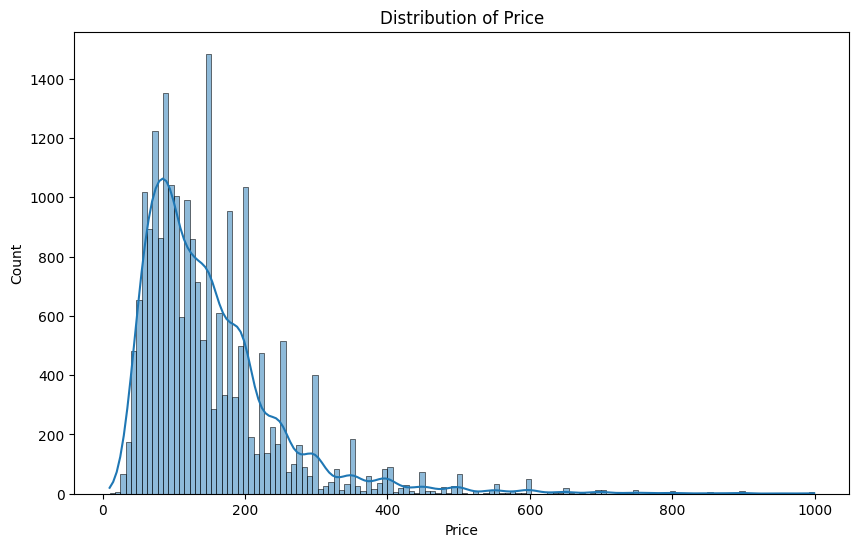

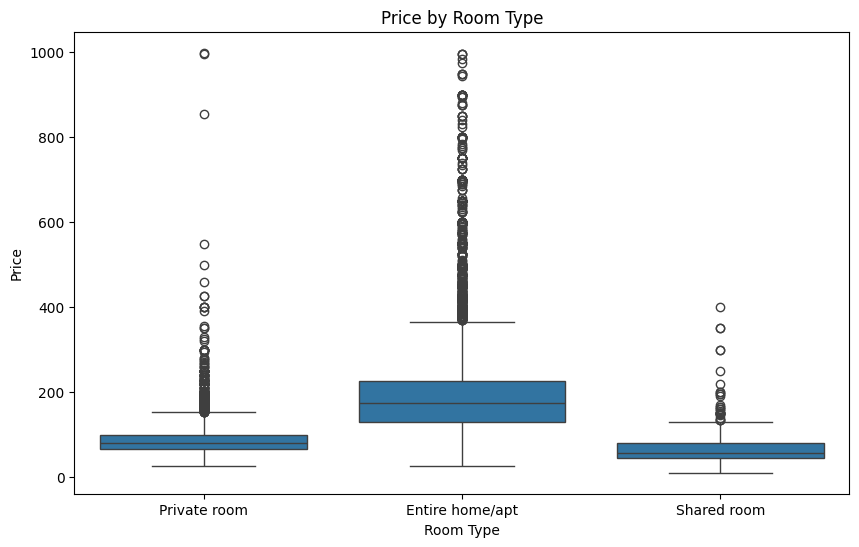

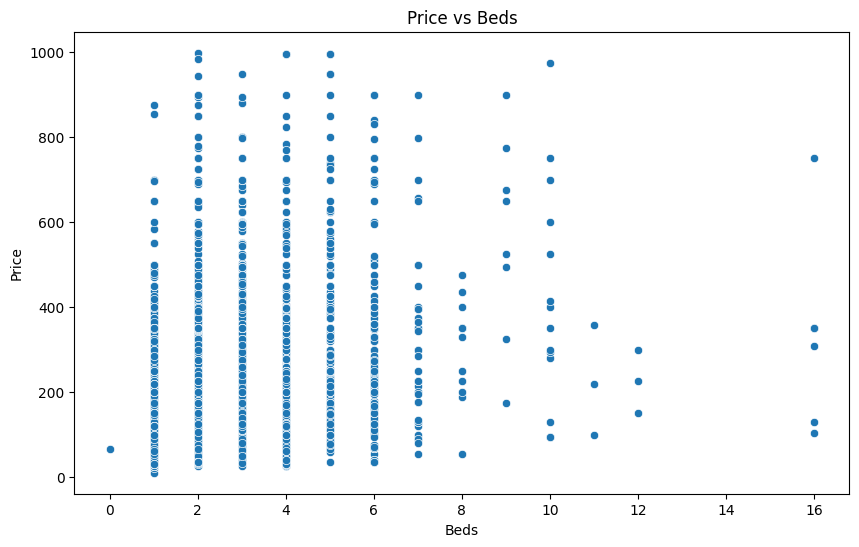

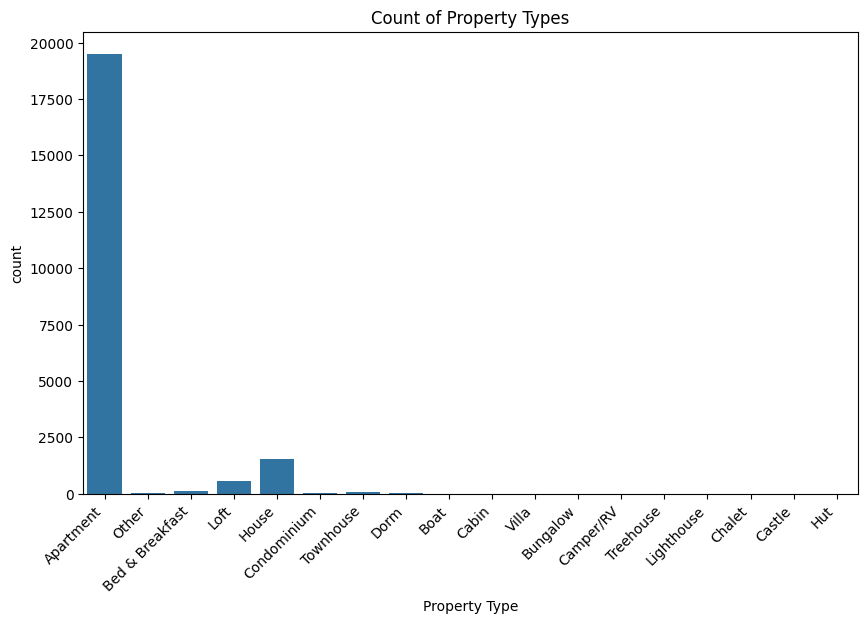

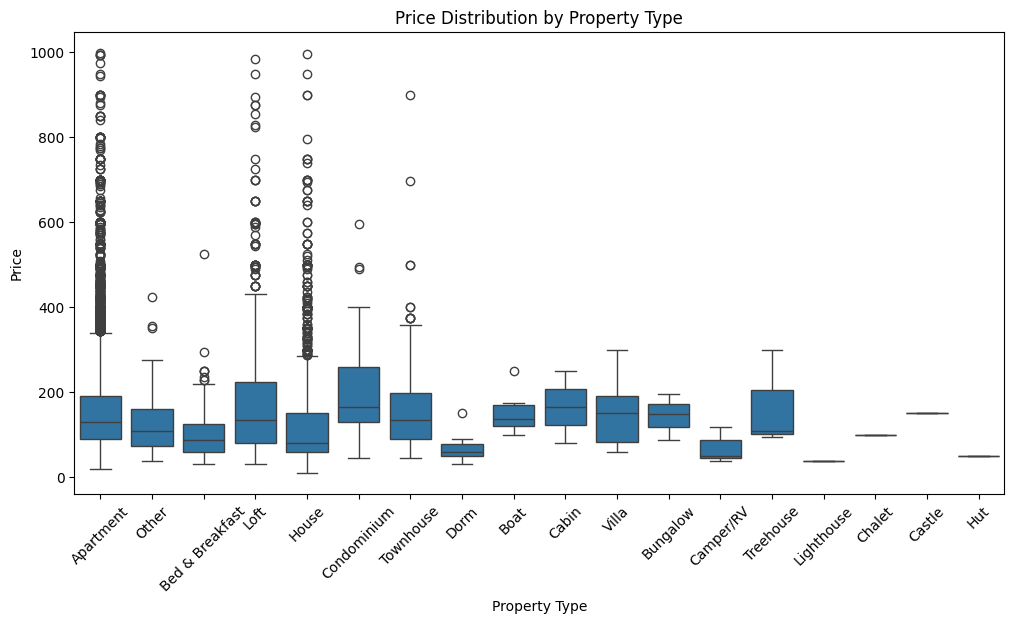

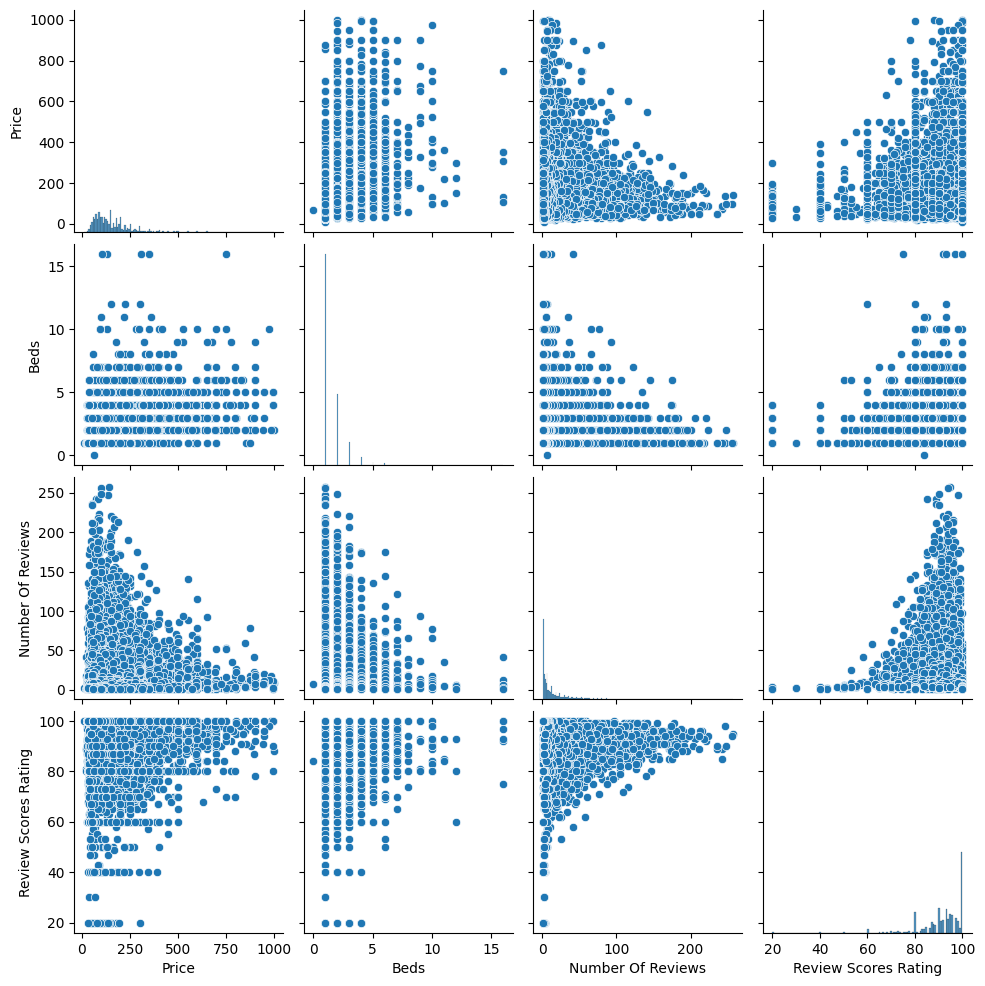

In [107]:
# used help of ai to create EDAs

print(df.describe())


plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Room Type', y='Price', data=df)
plt.title('Price by Room Type')
plt.show()


plt.figure(figsize=(10,6))
sns.scatterplot(x='Beds', y='Price', data=df)
plt.title('Price vs Beds')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Property Type', data=df)
plt.title('Count of Property Types')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.show()



# Explore relationships between categorical variables and price
# Example: Boxplot of price by 'Property Type'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Property Type', y='Price', data=df)
plt.title('Price Distribution by Property Type')
plt.xticks(rotation=45)
plt.show()

# Pairplot for numerical variables (select a subset for better visualization)
numerical_cols = ['Price', 'Beds', 'Number Of Reviews', 'Review Scores Rating']
sns.pairplot(df[numerical_cols])
plt.show()


2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.


In [108]:
df.head()

,Host Id,Host Since,Name,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Neighbourhood
4,500,6/26/2008,Trendy Times Square Loft,Apartment,95.0,Private room,10036.0,3.0,1,39,549.0,96.0,Manhattan
5,1039,7/25/2008,Big Greenpoint 1BD w/ Skyline View,Apartment,100.0,Entire home/apt,11222.0,1.0,1,4,149.0,100.0,Brooklyn
6,1783,8/12/2008,Amazing Also,Apartment,100.0,Entire home/apt,10004.0,1.0,1,9,250.0,100.0,Manhattan
7,2078,8/15/2008,"Colorful, quiet, & near the subway!",Apartment,90.0,Private room,11201.0,1.0,1,80,90.0,94.0,Brooklyn
8,2339,8/20/2008,East Village Cocoon: 2 Bedroom Flat,Apartment,90.0,Entire home/apt,10009.0,2.0,1,95,270.0,90.0,Manhattan


In [109]:
df.columns

Index(['Host Id', 'Host Since', 'Name', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating', 'Neighbourhood'],
      dtype='object')

In [110]:
# making host since numerical

y = df['Price']


df["Host Since Year"] = pd.to_datetime(df["Host Since"]).dt.year

df = df.drop(columns=["Host Since"])



,Host Id,Name,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Neighbourhood,Host Since Year
4,500,Trendy Times Square Loft,Apartment,95.0,Private room,10036.0,3.0,1,39,549.0,96.0,Manhattan,2008
5,1039,Big Greenpoint 1BD w/ Skyline View,Apartment,100.0,Entire home/apt,11222.0,1.0,1,4,149.0,100.0,Brooklyn,2008
6,1783,Amazing Also,Apartment,100.0,Entire home/apt,10004.0,1.0,1,9,250.0,100.0,Manhattan,2008
7,2078,"Colorful, quiet, & near the subway!",Apartment,90.0,Private room,11201.0,1.0,1,80,90.0,94.0,Brooklyn,2008
8,2339,East Village Cocoon: 2 Bedroom Flat,Apartment,90.0,Entire home/apt,10009.0,2.0,1,95,270.0,90.0,Manhattan,2008


In [111]:

X_d = pd.get_dummies(df['Neighbourhood'],dtype='int') # Create brand dummies

X_d2 = pd.get_dummies(df['Property Type'],dtype='int') # Create brand dummies


X_d3 = pd.get_dummies(df['Room Type'],dtype='int') # Create brand dummies

X_d4 = pd.get_dummies(df['Zipcode'],dtype='int') # Create brand dummies

X = pd.concat([df.drop(columns=['Neighbourhood', 'Property Type', 'Room Type', 'Zipcode', 'Price', 'Name', 'Host Id']) ,X_d, X_d2], axis=1) # Concatenate engineered features
X.head()



,Review Scores Rating (bin),Beds,Number of Records,Number Of Reviews,Review Scores Rating,Host Since Year,Bronx,Brooklyn,Manhattan,Queens,...,Condominium,Dorm,House,Hut,Lighthouse,Loft,Other,Townhouse,Treehouse,Villa
4,95.0,3.0,1,39,96.0,2008,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,100.0,1.0,1,4,100.0,2008,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,100.0,1.0,1,9,100.0,2008,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,90.0,1.0,1,80,94.0,2008,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,90.0,2.0,1,95,90.0,2008,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


3. Implement an 80/20 train-test split. Put the test data aside.
